# Banknote Classification for NBU IT Challenge

In [0]:
# Install library for pretrained efficientnet.

!pip install efficientnet_pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import os
import glob
import time
import shutil
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

In [0]:
# Working from Colab directory.
cd /content/drive/My Drive/Banknotes

In [0]:
DATA_FOLDER = './banknotes'  # folder with given dataset
BATCH_SIZE = 4  # size of the batch (is used while training the model)
EPOCHS = 15  # number of epochs (is used while training the model)
MODEL_PATH = './trained_models'  # path to trained models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on {}.".format("GPU" if torch.cuda.is_available() else "CPU"))

## Preprocessing Data

In [0]:
# Getting name for every class in the task.

with open(os.path.join(DATA_FOLDER, 'labels.txt'), "r") as f:
    classes_text = f.read()

classes = classes_text.split('\n')
print(classes_text)

1 гривня (зразка 2006 р)
1 гривня (зразка 2006 р, зворотнiй бiк)
2 гривнi (зразка 2004 р)
2 гривнi (зразка 2004 р, зворотнiй бiк)
5 гривень (зразка 2004 р)
5 гривень (зразка 2004 р, зворотнiй бiк)
10 гривень (зразка 2004 р)
10 гривень (зразка 2004 р, зворотнiй бiк)
20 гривень (зразка 2003 р)
20 гривень (зразка 2003 р, зворотнiй бiк)
50 гривень (зразка 2004 р)
50 гривень (зразка 2004 р, зворотнiй бiк)
100 гривень (зразка 2005 р)
100 гривень (зразка 2005 р, зворотнiй бiк)
200 гривень (зразка 2007 р)
200 гривень (зразка 2007 р, зворотнiй бiк)
500 гривень (зразка 2006 р)
500 гривень (зразка 2006 р, зворотнiй бiк)
1000 гривень (зразка 2019 р)
1000 гривень (зразка 2019 р, зворотнiй бiк)
500 гривень (зразка 2015 р)
500 гривень (зразка 2015 р, зворотнiй бiк)
100 гривень (зразка 2014 р)
100 гривень (зразка 2014 р, зворотнiй бiк)
20 гривень (зразка 2018 р)
20 гривень (зразка 2018 р, зворотнiй бiк)
50 гривень (зразка 2019 р)
50 гривень (зразка 2019 р, зворотнiй бiк)
200 гривень (зразка 2019 р)
20

In [0]:
# Gathering paths of every image in dataset.

data = []
filenames = sorted(os.listdir(DATA_FOLDER))  # names of all files in dataset dir
filenames = [fname for fname in filenames if fname != 'labels.txt'] # exclude labels
for fname in filenames:
    # Get string of full path to each image
    images = glob.glob(os.path.join(DATA_FOLDER, fname, '*.png'))
    images += glob.glob(os.path.join(DATA_FOLDER, fname, '*.jpg'))
    images += glob.glob(os.path.join(DATA_FOLDER, fname, '*.jpeg'))
    data.append((fname, images))

print(data[0][0], data[0][1][1])

01-1a ./banknotes/01-1a/tf-1537120529799.png


In [0]:
# Splitting all the images into train, dev, test sets.
train_dir = './train'
dev_dir = './dev'
test_dir = './test'
random.seed(42)

# Split only if you do it for the first time.
if not os.path.isdir(train_dir) or not os.path.isdir(dev_dir) or not os.path.isdir(test_dir):

    # Creating new directories for train, dev, test.
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(dev_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    for name, images in data:
        # Creating new directories for each class.
        os.makedirs(os.path.join(train_dir, name))
        os.makedirs(os.path.join(dev_dir, name))
        os.makedirs(os.path.join(test_dir, name))
        
        # Split proportion will be 8:1:1.
        train_end = int(0.8 * len(images))
        dev_end = int(0.9 * len(images))
        
        random.shuffle(images)
        
        train = images[:train_end]
        dev = images[train_end:dev_end]
        test = images[dev_end:]
        
        # Copy images into corresponding train, dev, test directories.
        for image_dir, images_in_dir in zip([train_dir, dev_dir, test_dir], [train, dev, test]):
            for image in images_in_dir:
                dst = os.path.join(os.path.join(image_dir, name), os.path.basename(image))
                shutil.copyfile(image, dst)

In [0]:
# Transforming all images to 224x224 pixel size.
transf = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Creating datasets from train, dev, test folders.
train_folder = ImageFolder(root=train_dir, transform=transf)
dev_folder = ImageFolder(root=dev_dir, transform=transf)
test_folder = ImageFolder(root=test_dir, transform=transf)

# Creating loaders from train, dev, test datasets.
train_loader = DataLoader(train_folder, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_folder, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_folder, batch_size=BATCH_SIZE, shuffle=True)

# Example of encoded labels.
images, labels = iter(train_loader).next()
print(labels)

tensor([ 8, 32, 21, 21])


## Model

In [0]:
class TransferedEfficientNet(nn.Module):
    """
    Pretrained EfficientNet as feature extractor + couple of FC Layers
    See: https://github.com/lukemelas/EfficientNet-PyTorch
    """
    def __init__(self):
        super(TransferedEfficientNet, self).__init__()
        self.feature_extractor = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc1 = nn.Linear(1280 * 7 * 7, 600)
        self.fc2 = nn.Linear(600, 33)
    
    def forward(self, x):
        x = self.feature_extractor.extract_features(x)
        x = x.view(-1, 1280 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [0]:
model = TransferedEfficientNet()
model.to(device)  # Converting to GPU, if can be done.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Loaded pretrained weights for efficientnet-b0


In [0]:
for epoch in range(EPOCHS):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  # get train data
        inputs, labels = data[0].to(device), data[1].to(device)  # gpu-convert
        optimizer.zero_grad()
        outputs = model(inputs)  # predicting
        loss = criterion(outputs, labels)
        loss.backward()  # backpropagation
        optimizer.step()

        # Print statistics.
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.177061
[1,   400] loss: 0.108458
[1,   600] loss: 0.101162
[1,   800] loss: 0.063807
[1,  1000] loss: 0.112956
[1,  1200] loss: 0.056641
[1,  1400] loss: 0.077417
[1,  1600] loss: 0.094577
[2,   200] loss: 0.025798
[2,   400] loss: 0.061698
[2,   600] loss: 0.033727
[2,   800] loss: 0.045993
[2,  1000] loss: 0.055927
[2,  1200] loss: 0.048459
[2,  1400] loss: 0.103440
[2,  1600] loss: 0.084773
[3,   200] loss: 0.019671
[3,   400] loss: 0.035872
[3,   600] loss: 0.052615
[3,   800] loss: 0.050675
[3,  1000] loss: 0.047617
[3,  1200] loss: 0.049439
[3,  1400] loss: 0.028554
[3,  1600] loss: 0.088216
[4,   200] loss: 0.073216
[4,   400] loss: 0.037825
[4,   600] loss: 0.029505
[4,   800] loss: 0.027841
[4,  1000] loss: 0.029820
[4,  1200] loss: 0.035000
[4,  1400] loss: 0.051208
[4,  1600] loss: 0.033724
[5,   200] loss: 0.045328
[5,   400] loss: 0.061352
[5,   600] loss: 0.032861
[5,   800] loss: 0.018015
[5,  1000] loss: 0.037142
[5,  1200] loss: 0.052822
[5,  1400] l

In [0]:
# Create dir for trained models.
os.makedirs(MODEL_PATH, exist_ok=True)

# Save the model.
str_time = time.strftime("%Y-%m-%d_%H:%M_model.pth", time.gmtime())
torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'augmented_98'))

## Testing

In [0]:
# Calculating accuracy on the dev images

correct = 0
total = 0
incorrect_examples = []
incorrect_labels = []
incorrect_predictions = []
with torch.no_grad():
    for data in dev_loader:  # load data from dev directory
        images, labels = data[0].to(device), data[1].to(device)  # gpu-convert
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        idxs_mask = (predicted != labels).view(-1)
        incorrect_examples.append(images[idxs_mask])
        labels = labels.cpu()
        incorrect_labels.append(np.array(labels)[idxs_mask.cpu()]) #true labels of images, that were misclassified
        predicted = predicted.cpu()
        incorrect_predictions.append(np.array(predicted)[idxs_mask.cpu()]) #predictions of images, that were misclassified
        
print('Accuracy on the dev images: %d %%' % (100 * correct / total))
print(total)
incorrect_images = torch.cat(incorrect_examples)

print(incorrect_images.size())


In [0]:
lbs = [label for label in incorrect_labels if len(label) != 0]
prs = [prediction for prediction in incorrect_predictions if len(prediction)!=0]

Let's take a look at the misclassified pictures. 
True label vs predicted one

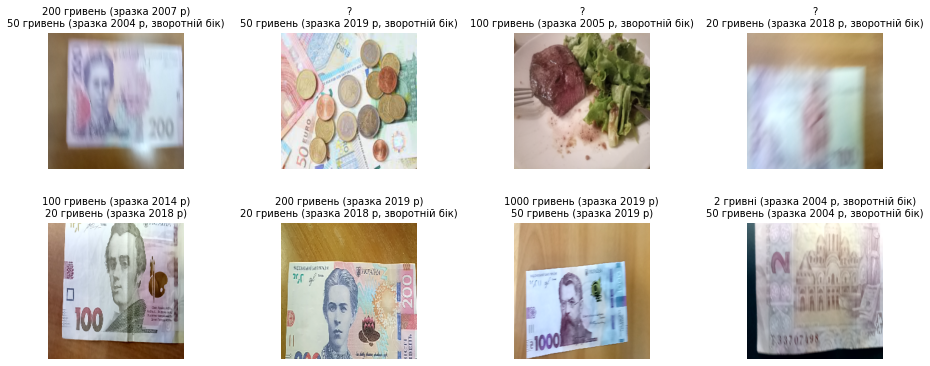

In [0]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (16,6))
gs1 = gridspec.GridSpec(2, 4)
gs1.update(wspace=0.2, hspace=0.4) # set the spacing between axes. 

for i in range(8):
    ax1 = plt.subplot(gs1[i])
    image = incorrect_images[i].cpu()
    plt.imshow( image.permute(1, 2, 0) )
    plt.axis('off')
    title = classes[lbs[i][0]] + '\n' + classes[prs[i][0]]
    ax1.set_title(title, fontsize= 10)
    #ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()

In [0]:
# Testing accuracy for each class on the dev set

class_correct = [0.0 for i in range(33)]
class_total = [0.0 for i in range(33)]
with torch.no_grad():
    for data in dev_loader:
        images, labels = data[0].to(device), data[1].to(device)  # For GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(33):
    print('Accuracy of %43s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of                    1 гривня (зразка 2006 р) : 100 %
Accuracy of     1 гривня (зразка 2006 р, зворотнiй бiк) : 100 %
Accuracy of                    2 гривнi (зразка 2004 р) : 100 %
Accuracy of     2 гривнi (зразка 2004 р, зворотнiй бiк) : 92 %
Accuracy of                   5 гривень (зразка 2004 р) : 100 %
Accuracy of    5 гривень (зразка 2004 р, зворотнiй бiк) : 100 %
Accuracy of                  10 гривень (зразка 2004 р) : 100 %
Accuracy of   10 гривень (зразка 2004 р, зворотнiй бiк) : 100 %
Accuracy of                  20 гривень (зразка 2003 р) : 100 %
Accuracy of   20 гривень (зразка 2003 р, зворотнiй бiк) : 100 %
Accuracy of                  50 гривень (зразка 2004 р) : 100 %
Accuracy of   50 гривень (зразка 2004 р, зворотнiй бiк) : 100 %
Accuracy of                 100 гривень (зразка 2005 р) : 100 %
Accuracy of  100 гривень (зразка 2005 р, зворотнiй бiк) : 100 %
Accuracy of                 200 гривень (зразка 2007 р) : 93 %
Accuracy of  200 гривень (зразка 2007 р, з

In [0]:
# Testing accuracy on the test

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)  # For GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 98 %


In [0]:
# Testing accuracy on the train set

correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)  # For GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the train images: %d %%' % (100 * correct / total))

Accuracy on the train images: 99 %


##Testing the model on other test pictures

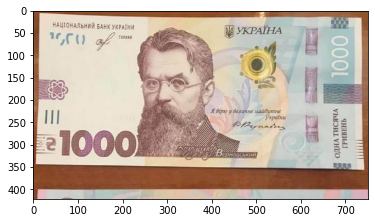

In [0]:
# open test image for testing
image = Image.open('image.jpg')
plt.imshow(image)

In [0]:
from torch.autograd import Variable

In [0]:
#transforms the image to the size for our model
loader = transforms.Compose([transforms.Resize((224, 224)),       
                            transforms.ToTensor()])

image = loader(image).float()
image = Variable(image, requires_grad=True)
image = image.cuda()


In [0]:
image.size()

torch.Size([3, 224, 224])

In [0]:
# loading our saved model 
model = TransferedEfficientNet()
model.to(device)  # For GPU
model.load_state_dict(torch.load('./trained_models/augmented_98'))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [0]:
#Getting predictions from the model.
output = model(image[None, ...])  


In [0]:
output.data

tensor([[-11.7813, -34.8114,  13.9156, -46.4369, -29.5594,  -6.2299,   4.9176,
         -80.1032, -45.7079, -22.4839, -41.4289, -67.7335,  38.5194, -13.0538,
         -52.8198, -60.9677, -42.5293, -52.4224,  71.5696, -59.1979, -26.3284,
         -14.2971, -28.3848, -15.1741, -40.7260, -28.8362,   2.5325,   2.5300,
         -24.1442,   0.3301, -58.8420, -52.9681, -20.9733]], device='cuda:0')

In [0]:
#most likely class
torch.max(output.data, 1) 

torch.return_types.max(values=tensor([71.5696], device='cuda:0'), indices=tensor([18], device='cuda:0'))

In [0]:
# Get top 3 results from output.
torch.topk(output.data, 3) 

torch.return_types.topk(values=tensor([[71.5696, 38.5194, 13.9156]], device='cuda:0'), indices=tensor([[18, 12,  2]], device='cuda:0'))

In [0]:
values, idx = torch.topk(output.data, 3)


In [0]:
for i in idx[0]:
  print(classes[i])


1000 гривень (зразка 2019 р)
100 гривень (зразка 2005 р)
2 гривнi (зразка 2004 р)


## Image augmentation with rotation 90, 180, 270 degrees

In [0]:
dirs = os.listdir('./train')


Let's augment data in train set with 3 rotations: 90, 180, 270 degrees. We will randomly choose 20 images of each class and apply transformations on them. 

In [0]:
for dir in dirs:
  train_dir_aug = './train/{}'.format(dir)
  images = [os.path.join(train_dir_aug , f) for f in os.listdir(train_dir_aug) if os.path.isfile(os.path.join(train_dir_aug, f))]
  num_generated_files = 0
  while num_generated_files < 20:
      # random image from the folder
      image_path = random.choice(images)
      # read image as an two dimensional array of pixels
      image_to_transform = Image.open(image_path)
      # add image with 90 degrees rotation
      transformed_image_90 = image_to_transform.transpose(Image.ROTATE_90)
      new_file_path = '%s/augmented_image_90_%s.png' % (train_dir_aug , num_generated_files)
      transformed_image_90.save(new_file_path)
      # add image with 180 degrees rotation
      transformed_image_180 = image_to_transform.transpose(Image.ROTATE_180)
      new_file_path = '%s/augmented_image_180_%s.png' % (train_dir_aug , num_generated_files)
      transformed_image_180.save(new_file_path)
      # add image with 270 degrees rotation
      transformed_image_270 = image_to_transform.transpose(Image.ROTATE_270)
      new_file_path = '%s/augmented_image_270_%s.png' % (train_dir_aug , num_generated_files)
      transformed_image_270.save(new_file_path)

      num_generated_files += 1